# H1C IDR3.2 RFI

In [1]:
import os
import h5py
import numpy as np
import scipy.linalg

import sys

sys.path.append("/users/pkeller/code/ClosurePhaseAnalysis/")

from library import rfi

from ipywidgets import interact

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# configure matplotlib
mpl.style.use("classic")

## Load Data

In [43]:
path = "/lustre/aoc/projects/hera/pkeller/data/H1C_IDR3.2/sample/EQ14_FC_B2.h5"

with h5py.File(path, "r") as f:
    jd = f["JD"][100]
    lst = f["LST"][()]
    RFI = f["bispec RFI"][100]

# generate frequency array
frqrange = [152.25, 167.97]
fmin, fmax, fN = (100, 200, 1024)
df = (fmax - fmin) / fN
frq = np.arange(frqrange[0], frqrange[1], df)

## Flag Data

In [44]:
RFIf = RFI.copy()
flags = np.zeros_like(RFIf).astype(bool)

## Median Data Products

In [45]:
# median filtered
data_f = rfi.moving_median_2D(RFIf, axes=(0, 1))

# variance
data_v = 1.4826 * rfi.moving_median_2D(np.abs(RFIf - data_f), axes=(0, 1), medtype="standard")

/users/pkeller/code/ClosurePhaseAnalysis/library/rfi.py:87: ComplexWarning: Casting complex values to real discards the imaginary part
  


## Flag Data

In [46]:
# median filtering
flags += rfi.median_clip_2D(RFIf, data_f, data_v)

In [47]:
N = 160 

# polynomial filter
for i in range(RFIf.shape[0] // (N//2) + 1):
    s = slice(i*N//2, i*N//2+N)
    flags[s] += rfi.poly_2D_clip(RFIf[s], zth=3, zth_adj=2)    

In [52]:
import imp; imp.reload(rfi)
N = 160 

# polynomial filter
for i in range(RFIf.shape[0] // N + 1):
    s = slice(i*N, (i+1)*N)
    
    RFIf_poly = rfi.poly_2D_fit(RFIf[s], 16, 16)
    res = np.abs(RFIf[s] - RFIf_poly)
    z = res / rfi.moving_median_2D(res, axes=(0, 1), medtype="standard")
    z = np.nanmean(z, axis=-1)
    z = z / (rfi.moving_median(z))
    idx = np.where(z > 1.2)[0]
    flags[s][idx] = True    

/users/pkeller/code/ClosurePhaseAnalysis/library/rfi.py:87: ComplexWarning: Casting complex values to real discards the imaginary part
  
/users/pkeller/code/ClosurePhaseAnalysis/library/rfi.py:87: ComplexWarning: Casting complex values to real discards the imaginary part
  
/users/pkeller/code/ClosurePhaseAnalysis/library/rfi.py:87: ComplexWarning: Casting complex values to real discards the imaginary part
  
/users/pkeller/code/ClosurePhaseAnalysis/library/rfi.py:87: ComplexWarning: Casting complex values to real discards the imaginary part
  
/users/pkeller/code/ClosurePhaseAnalysis/library/rfi.py:87: ComplexWarning: Casting complex values to real discards the imaginary part
  


## Polynomial Fit

In [55]:
model = rfi.poly_2D_fit(RFIf, 72, 16)
model_v = 1.4826 * rfi.moving_median_2D(np.abs(RFIf - model), axes=(0, 1))

## Plot Spectrogram

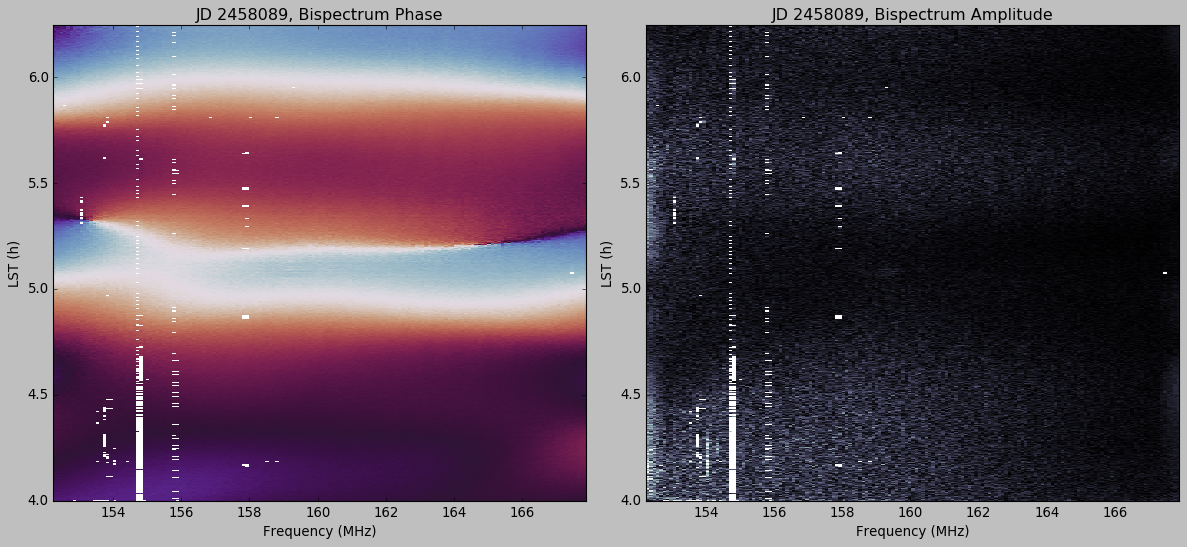

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
im1 = ax[0].imshow(
    np.angle(RFIf),
    extent=(np.amin(frq), np.amax(frq), np.amin(lst), np.amax(lst)),
    cmap=cm.twilight,
    interpolation="None",
    aspect="auto",
    
)
im2 = ax[1].imshow(
    np.abs((RFIf-data_f)),
    extent=(np.amin(frq), np.amax(frq), np.amin(lst), np.amax(lst)),
    cmap=cm.bone,
    interpolation="None",
    aspect="auto",
    vmin=0, 
    vmax=1e-5,
)
    
ax[0].set_title(f"JD {jd}, Bispectrum Phase")
ax[1].set_title(f"JD {jd}, Bispectrum Amplitude")
plt.setp(ax, xlabel="Frequency (MHz)", ylabel="LST (h)", ylim=[min(lst), max(lst)])
plt.tight_layout()
plt.show()

## Plot Time Slice

In [37]:
def plot(t):
    print(f"{lst[t]} h")
    
    idx = ~np.isnan(RFIf[t])

    nsig = 3
    fit = model[t][idx]
    
    res = RFIf[t][idx] - fit
    std = np.nanstd(res)
        
    fig, ax = plt.subplots(1, 2, figsize=(15, 7), sharey=True)
    ax[0].scatter(frq[idx], RFIf[t][idx].real, s=0.5)
    ax[1].scatter(frq[idx], RFIf[t][idx].imag, s=0.5)
    ax[0].plot(frq[idx], fit.real)
    ax[1].plot(frq[idx], fit.imag)
    ax[0].plot(frq[idx], (fit.real + nsig * std), color="orange")
    ax[1].plot(frq[idx], (fit.imag + nsig * std), color="orange")
    ax[0].plot(frq[idx], (fit.real - nsig * std), color="orange")
    ax[1].plot(frq[idx], (fit.imag - nsig * std), color="orange")
    ax[0].scatter(frq[~idx], RFI[t][~idx].real, s=10, color="r")
    ax[1].scatter(frq[~idx], RFI[t][~idx].imag, s=10, color="r")
    
    ax[0].set_title(f"JD {jd}, Real")
    ax[1].set_title(f"JD {jd}, Imaginary")
    plt.setp(ax, xlabel="Frequency (MHz)", ylabel="Bispectrum", xlim=[min(frq), max(frq)], ylim=[-5*1e-5, 5*1e-5])
    
    plt.tight_layout()
    plt.show()

interact(plot, t=(0, len(lst)-1))

interactive(children=(IntSlider(value=375, description='t', max=751), Output()), _dom_classes=('widget-interac…

<function __main__.plot(t)>

## Plot Frequency Slice

In [38]:
n = 120

def plot(t, f):
    print(f"{frq[f]} MHz")
    s = slice(t*n, (t+1)*n)
    
    idx = ~np.isnan(RFIf[s, f])
    nsig = 3
    
    fit = model[s, f][idx]
    std = model_v[s, f][idx]
        
    fig, ax = plt.subplots(1, 2, figsize=(15, 7), sharey=True)
    ax[0].scatter(lst[s], RFIf[s, f].real, s=0.5)
    ax[1].scatter(lst[s], RFIf[s, f].imag, s=0.5)
    ax[0].plot(lst[s][idx], fit.real)
    ax[1].plot(lst[s][idx], fit.imag)
    ax[0].plot(lst[s][idx], (fit.real + nsig * std), color="orange")
    ax[1].plot(lst[s][idx], (fit.imag + nsig * std), color="orange")
    ax[0].plot(lst[s][idx], (fit.real - nsig * std), color="orange")
    ax[1].plot(lst[s][idx], (fit.imag - nsig * std), color="orange")
    ax[0].scatter(lst[s][~idx], RFI[s, f][~idx].real, s=10, color="r")
    ax[1].scatter(lst[s][~idx], RFI[s, f][~idx].imag, s=10, color="r")
    
    ax[0].set_title(f"JD {jd}, Real")
    ax[1].set_title(f"JD {jd}, Imaginary")
    plt.setp(ax, xlabel="LST (h)", ylabel="Bispectrum", xlim=[min(lst[s]), max(lst[s])], ylim=[-1e-4, 1e-4])
    
    plt.tight_layout()
    plt.show()

interact(plot, t=(0, RFIf.shape[0] // n), f=(0, len(frq)-1))

interactive(children=(IntSlider(value=3, description='t', max=6), IntSlider(value=80, description='f', max=160…

<function __main__.plot(t, f)>